In [1]:
from __future__ import division, print_function

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):    
    plt.figure(figsize=(12,6))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc='upper right', frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.2, np.pi)
    plt.ylim(-1.5, 1.5)    
    plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="xx-large", 
             color="k",
             ha='left', 
             va='top')
    plt.axis("off")

In [5]:
style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"

In [6]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, marker='.', label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Main Problem**

In [7]:
def f_rhs(x):
   return -4*torch.sin(2 * x)

def exact_u(x):
    return torch.sin(2 * x)

def exact_u_singular(x):
  return x**0.7 * (x - torch.pi)

def f_singular_rhs(x):
  return -0.7 * 0.3 * (x**-1.3) * (x - torch.pi) + (0.7*x**-0.3) * (1) + (0.7 * x**-0.3)  

class TransformerEDP(nn.Module):    
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(TransformerEDP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1, activation='relu'), 
            num_layers
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):        
        x = self.encoder(x)  
        output = self.transformer_encoder(x)  
        output = self.decoder(output)
        return output 

**Training Data**

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([10, 1]) torch.Size([10, 1])


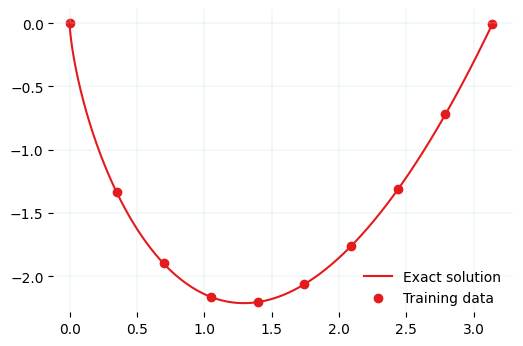

In [8]:
n_pts = 1000

x = np.array([np.pi/n_pts * i for i in range(n_pts)])
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = exact_u_singular(x).view(-1, 1)
print(x.shape, y.shape)

num_samples = 10
indices = np.linspace(0, len(x)-1, num_samples, dtype=int)
x_data = x[indices]
y_data = y[indices]
print(x_data.shape, y_data.shape)

with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")        
        plt.scatter(x_data, y_data, label='Training data')        
        plt.legend()
        plt.show()

### **Normal Encoder Transformer**

In [9]:
torch.manual_seed(123)
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=12)
model

TransformerEDP(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): Tanh()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
  )
)

**Params**

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 103805


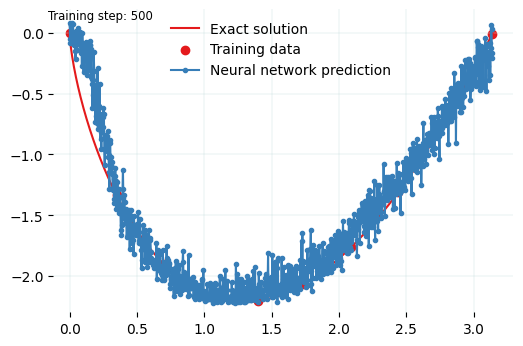

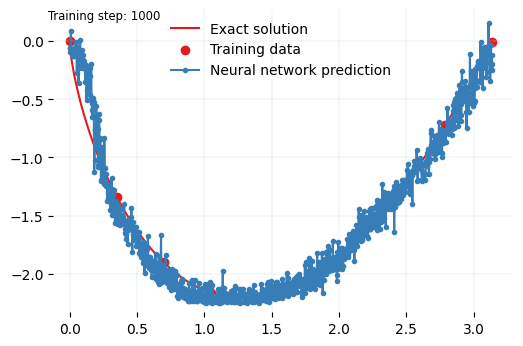

ValueError: images do not match

In [13]:
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=12)
n_iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(n_iterations):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        yh = model(x).detach()
        style_plot(x, y, x_data, y_data, yh)
        file = "plots/nn_%.8i.png"%(i+1)    
        plt.savefig(file, bbox_inches='tight', pad_inches=0.5, dpi=100, facecolor="white")
        files.append(file)

    if (i+1) % 500 == 0: plt.show()
    else: plt.close("all")
save_gif_PIL("nn.gif", files, fps=20, loop=0)

### **PITN**

Loss at iteration 10: 132715.156250
Loss at iteration 20: 131716.437500
Loss at iteration 30: 131725.125000
Loss at iteration 40: 131706.109375
Loss at iteration 50: 131617.484375
Loss at iteration 60: 131334.718750
Loss at iteration 70: 131257.718750
Loss at iteration 80: 133287.921875
Loss at iteration 90: 130862.898438
Loss at iteration 100: 129867.093750
Loss at iteration 110: 109049.382812
Loss at iteration 120: 131576.343750
Loss at iteration 130: 131705.375000
Loss at iteration 140: 131690.250000
Loss at iteration 150: 131710.265625
Loss at iteration 160: 131670.609375
Loss at iteration 170: 131633.406250
Loss at iteration 180: 131420.875000
Loss at iteration 190: 131149.937500
Loss at iteration 200: 130915.015625
Loss at iteration 210: 130051.101562
Loss at iteration 220: 118903.898438
Loss at iteration 230: 130662.734375
Loss at iteration 240: 131682.984375
Loss at iteration 250: 131706.437500
Loss at iteration 260: 131711.203125
Loss at iteration 270: 131710.515625
Loss at it

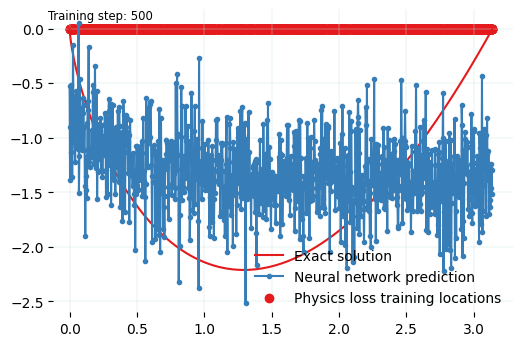

Loss at iteration 510: 114279.554688
Loss at iteration 520: 120539.000000
Loss at iteration 530: 113696.640625
Loss at iteration 540: 117593.953125
Loss at iteration 550: 122065.125000
Loss at iteration 560: 127756.359375
Loss at iteration 570: 127274.414062
Loss at iteration 580: 116635.031250
Loss at iteration 590: 122721.664062
Loss at iteration 600: 117289.953125
Loss at iteration 610: 120511.039062
Loss at iteration 620: 126605.164062
Loss at iteration 630: 122566.921875
Loss at iteration 640: 118320.562500
Loss at iteration 650: 105337.453125
Loss at iteration 660: 128166.500000
Loss at iteration 670: 110127.921875
Loss at iteration 680: 116616.570312
Loss at iteration 690: 108997.718750
Loss at iteration 700: 126826.000000
Loss at iteration 710: 130277.078125
Loss at iteration 720: 130438.710938
Loss at iteration 730: 129822.429688
Loss at iteration 740: 130280.109375
Loss at iteration 750: 130136.265625
Loss at iteration 760: 129597.828125
Loss at iteration 770: 127513.351562
L

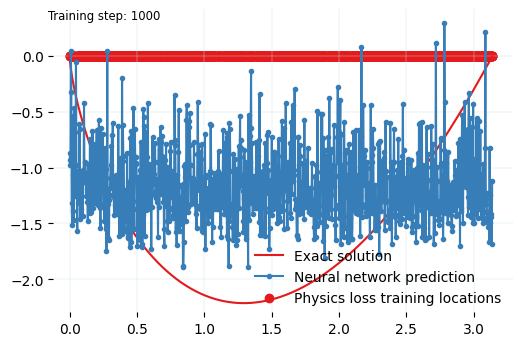

In [15]:
x_physics = torch.FloatTensor(2000,1).uniform_(0, np.pi).requires_grad_(True)
x_physics = x_physics.unsqueeze(0)
iterations = 1000

torch.manual_seed(123)
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=12)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
for i in range(iterations):
    optimizer.zero_grad()    

    yh = model(x_data)
    loss_data = torch.mean((yh-y_data)**2)
    
    # Physics loss
    yhp = model(x_physics)
    du = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    ddu = torch.autograd.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]
    error_PDE = torch.mean((ddu - f_singular_rhs(x_physics))**2)
    bc = model(torch.tensor([np.pi]).unsqueeze(0))**2 + model(torch.tensor([0.]).unsqueeze(0))**2
    loss_physics = error_PDE + bc

    # Backpropagation
    loss = loss_data + loss_physics
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (i+1) % 10 == 0:
        print(f"Loss at iteration {i+1}: {loss.item():.6f}")

    if (i+1) % 500 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        style_plot(x, y, x_data=None, y_data=None, yh=yh, xp=xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 100 == 0: plt.show()
        else: plt.close("all")
save_gif_PIL("pinn.gif", files, fps=15, loop=0)

**Loss Function**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


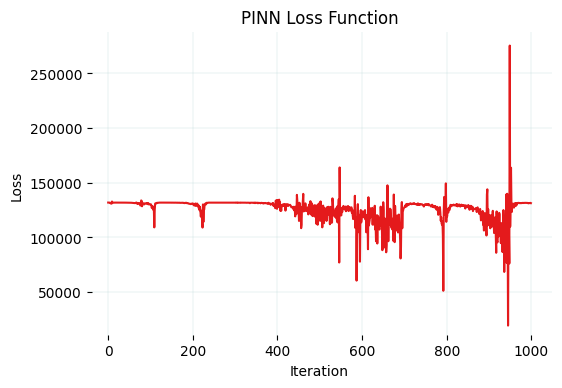

In [16]:
with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.title("PINN Loss Function")
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel('Loss')             
        plt.legend()
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


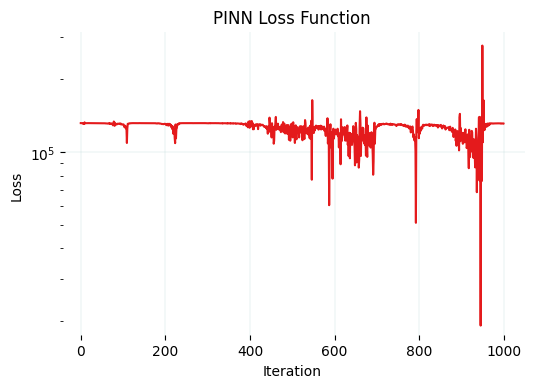

In [17]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.semilogy(losses)  # Cambio aquí
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()
    plt.show()

**Save PITN model**

In [46]:
torch.save(model.state_dict(), "models/poisson1_pitn.pth")

In [47]:
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=12)
model.load_state_dict(torch.load("models/poisson1_pitn.pth"))

<All keys matched successfully>

In [48]:
model.eval()

TransformerEDP(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): Tanh()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
  )
)